# Character-level recurrent sequence-to-sequence model

**Credits to:** [fchollet](https://twitter.com/fchollet)<br>
**Author:** Mohammed Handa<br>
**Date created:** 2023/04/25<br>
**Last modified:** 2023/04/25<br>
**Description:** Word-level recurrent sequence-to-sequence model.

## Introduction

This is a basic word-level recurrent sequence-to-sequence model for translating short English sentences into short French sentences.

*This notebook is a derived version of the [original notebook](https://keras.io/examples/nlp/lstm_seq2seq) written by fchollet. For more details refer to the original notebook.*

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.


## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from re import sub


## Configuration


In [2]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"


## Prepare the data


In [3]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()
max_encoder_seq_length = 0
max_decoder_seq_length = 0
with open(data_path, "r", encoding="utf-8") as f:
  lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
  input_text, target_text = line.split("\t")
  target_text = "\t" + target_text + "\n"
  input_text = sub("[.,?!]", "", input_text)
  input_text = input_text.lower()
  target_text = sub("[.,?!]", "", target_text)
  target_text = target_text.lower()
  input_texts.append(input_text)
  target_texts.append(target_text)
  input_text_words = input_text.split()
  target_text_words = target_text.split()
  input_len = len(input_text_words)
  target_len = len(target_text_words)
  max_encoder_seq_length = max(max_encoder_seq_length, input_len)
  max_decoder_seq_length = max(max_decoder_seq_length, target_len)
  for word in input_text_words:
    if word not in input_words:
      input_words.add(word)
  for word in target_text_words:
    if word not in target_words:
      target_words.add(word)

input_words.add(" ")
target_words.add(" ")
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(word, i)
                         for i, word in enumerate(input_words)])
target_token_index = dict([(word, i)
                          for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, word in enumerate(input_text.split()):
    encoder_input_data[i, t, input_token_index[word]] = 1.0
  encoder_input_data[i, t + 1:, input_token_index[" "]] = 1.0
  for t, word in enumerate(target_text.split()):
    # decoder_target_data is ahead of decoder_input_data by one timestep
    decoder_input_data[i, t, target_token_index[word]] = 1.0
    if t > 0:
      # decoder_target_data will be ahead by one timestep
      # and will not include the start character.
      decoder_target_data[i, t - 1, target_token_index[word]] = 1.0
  decoder_input_data[i, t + 1:, target_token_index[" "]] = 1.0
  decoder_target_data[i, t:, target_token_index[" "]] = 1.0
  pass


Number of samples: 10000
Number of unique input tokens: 2217
Number of unique output tokens: 4648
Max sequence length for inputs: 5
Max sequence length for outputs: 10


## Build the model


In [4]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


## Visualize the model

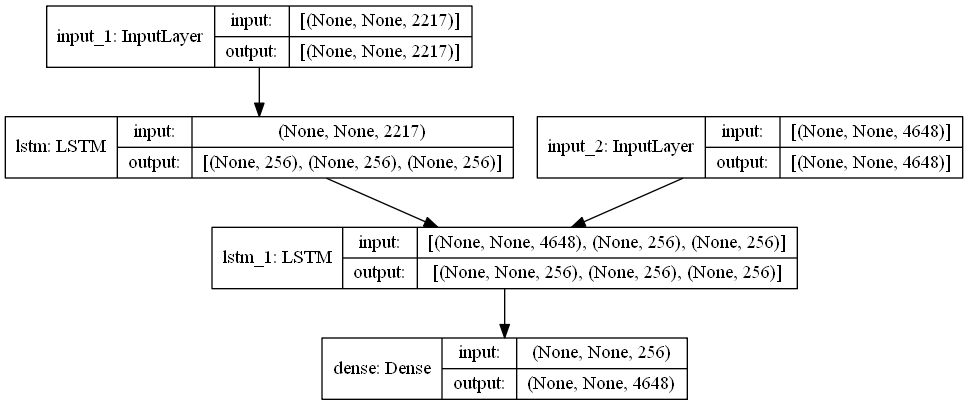

In [5]:
keras.utils.plot_model(model, "lstm_seq2seq.png", show_shapes=True)

## Train the model


In [6]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s_word_level")


Epoch 1/100
124/125 [============================>.] - ETA: 0s - loss: 1.9758 - accuracy: 0.7769

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s_word_level")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



In [ ]:
# visualize encoder_model
keras.utils.plot_model(encoder_model, "encoder_model.png", show_shapes=True)

In [ ]:
# visualize decoder_model
keras.utils.plot_model(decoder_model, "decoder_model.png", show_shapes=True)

You can now generate decoded sentences as such:


In [ ]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)


In [ ]:
def translate(input_text):
    input_seq = np.zeros((1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")
    for t, char in enumerate(input_text):
        input_seq[0, t, input_token_index[char]] = 1.0
    decoded_sentence = decode_sequence(input_seq)
    return decoded_sentence

In [ ]:
test_data = [
    "I am a student",
    "I am a woman",
    "How are you?",
    "Where are you?",
    "is she a fine?",
    "Where is she?",
    "How is she?",
    "Give it to me",
    "Show me how",
    "I can do it",
    "Who is this?"
]

for input_text in test_data:
    print("input text:", input_text)
    print("translated text:", translate(input_text))
    print()
